In [2]:
from sklearn.cluster import KMeans, SpectralClustering
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
import online_dictionary_learning.omp as omp

In [3]:
salinas_mat = spio.loadmat('data/Salinas/salinas.mat')
salinas_gt_mat = spio.loadmat('data/Salinas/salinas_gt.mat')
salinas_image = salinas_mat['salinasA_corrected']
salinas_gt = salinas_gt_mat['salinasA_gt']

salinas_dictionary = np.load('results/Salinas/t5000_k220_L2.npy')

In [6]:
def kmeans_compare(image, gt, dictionary, verbose=False):
    # Original shape of image
    original_shape = gt.shape
    # flatten image and gt data
    image_flat = np.reshape(image, (-1, image.shape[2]))
    gt_flat = np.reshape(gt, (-1))
    # Remove Misc. Data
    image_flat = image_flat[gt_flat!=0]
    
    # Compute Sparse Coefficients
    coefs = np.zeros((image_flat.shape[0], dictionary.shape[1]))
    
    if verbose:
        print('Computing sparse coefficients:\n')
    
    for i in range(coefs.shape[0]):
        coefs[i]=omp.omp(dictionary, image_flat[i], L=5, eps=None)
        if verbose:
            if i+1<image_flat.shape[0]:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\r')
            else:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\n')

    # Run K-Means for both data sets
    k = np.unique(gt_flat).shape[0]-1
    kmeans_o = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=0).fit(coefs)
    # kmeans_o = KMeans(n_clusters=k, random_state=0).fit(image_flat)
    kmeans_s = SpectralClustering(n_clusters=k, random_state=0, affinity='nearest_neighbors').fit(image_flat)
    
    # Get labels
    labels_o = kmeans_o.labels_
    labels_s = kmeans_s.labels_
    
    # Reconstruct Images
    
    count, loc, n = 0, 0, gt_flat.shape[0]
    final_o, final_s = np.zeros(n), np.zeros(n)
    while count<labels_o.shape[0]:
        if (gt_flat[loc]!=0):
            final_o[loc]=labels_o[count]+1
            final_s[loc]=labels_s[count]+1
            count+=1
        loc+=1
    

    # Reshape
    final_o, final_s = np.reshape(final_o, original_shape), np.reshape(final_s, original_shape)
    
    # Return
    return [final_o, final_s]

/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


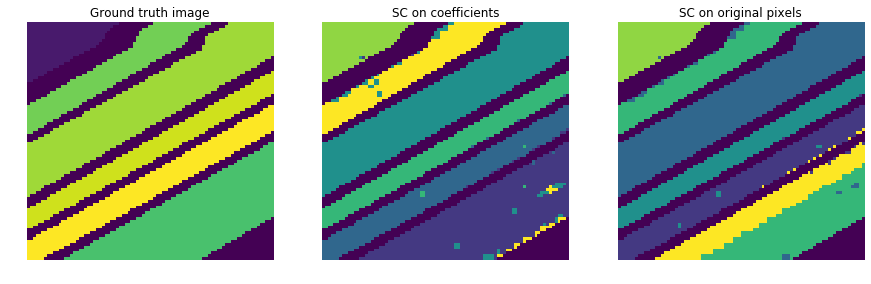

In [10]:
clusterings = kmeans_compare(image=salinas_image, gt=salinas_gt, dictionary=salinas_dictionary, verbose=False)

f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(salinas_gt)
ax[1].imshow(clusterings[0])
ax[2].imshow(clusterings[1])
ax[0].title.set_text('Ground truth image')
ax[1].title.set_text('SC on coefficients')
ax[2].title.set_text('SC on original pixels')
plt.savefig('spectral_result.png')

for a in ax:
    a.axis('off')

plt.show()